# Data Analysis Pipeline

This notebook loads a CSV, inspects and cleans the data, creates EDA plots, applies four scalers (Robust, Standard, MinMax, MaxAbs), trains/evaluates three models (XGBoost, CatBoost, LightGBM or sklearn fallbacks), saves confusion matrices and a summary CSV.

**Notes:** The notebook expects the CSV at `/mnt/data/Test_data.csv`. Output artifacts will be written to `/mnt/data/report_output`.


In [1]:

# Imports
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='pastel')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from collections import Counter
import time
import json

# Paths
DATA_PATH = Path("C:\\Users\\Rahul\\Desktop\\internship project\\Test_data.csv")
OUTPUT_DIR = Path('C:\\Users\\Rahul\\Desktop\\internship project\\report_output')
PLOTS_DIR = Path ('C:\\Users\\Rahul\\Desktop\\internship project\\report_output\\plot')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print('DATA_PATH exists?', DATA_PATH.exists())
print('Outputs will be saved to:', OUTPUT_DIR)


DATA_PATH exists? True
Outputs will be saved to: C:\Users\Rahul\Desktop\internship project\report_output


In [2]:

# Helper: sanitize filenames (Windows-safe)
import re
def sanitize_filename(name: str) -> str:
    # replace illegal chars with underscore and strip leading/trailing spaces
    return re.sub(r'[<>:"/\\|?*]', '_', str(name)).strip()


In [3]:

# Load data
df = pd.read_csv(DATA_PATH)
print('Loaded shape:', df.shape)
display(df.head())
print('\nData types:')
display(df.dtypes)

print('\nMissing value counts:')
display(df.isnull().sum())


Loaded shape: (23490, 13)


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61



Data types:


employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
dtype: object


Missing value counts:


employee_id                0
department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    1812
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
dtype: int64

In [4]:

# Fill NULLs (numeric -> median, categorical -> mode) and drop duplicates
def fill_nulls(df):
    df = df.copy()
    numeric_cols = df.select_dtypes(include=['number']).columns
    categorical_cols = df.select_dtypes(include=['object','category','bool']).columns
    for c in numeric_cols:
        df[c].fillna(df[c].median(), inplace=True)
    for c in categorical_cols:
        if df[c].mode().size>0:
            df[c].fillna(df[c].mode()[0], inplace=True)
        else:
            df[c].fillna('', inplace=True)
    return df

df_clean = fill_nulls(df)
before = df_clean.shape[0]
df_clean = df_clean.drop_duplicates()
after = df_clean.shape[0]
print(f'Dropped duplicates: {before-after}')
display(df_clean.head())


Dropped duplicates: 0


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,3.0,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


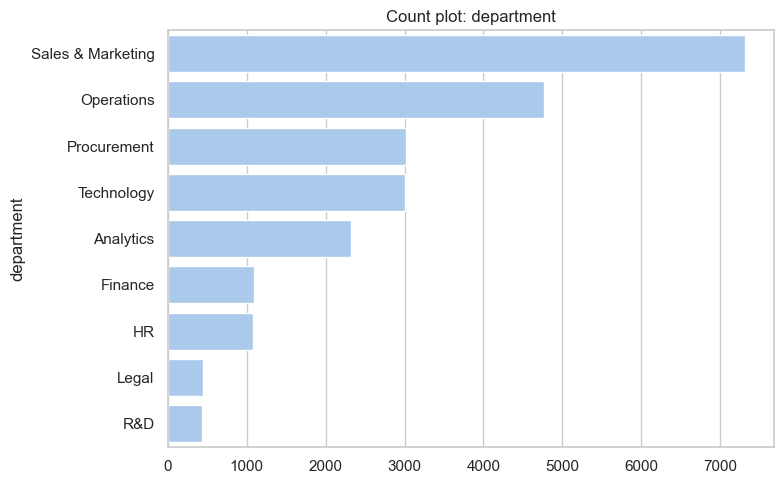

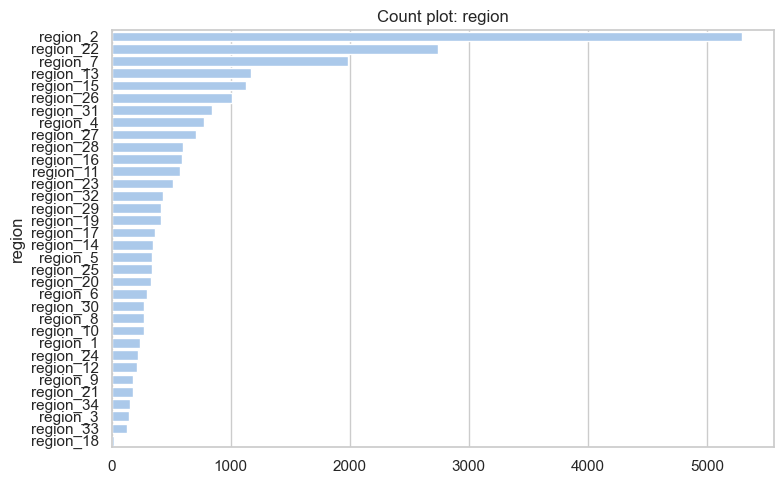

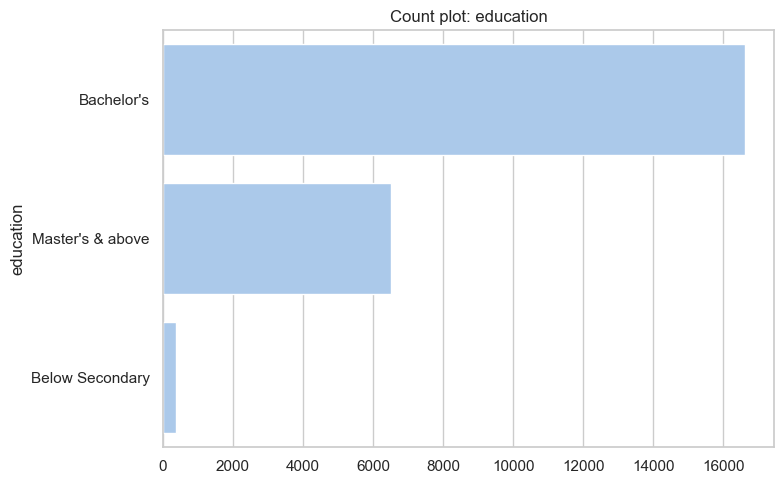

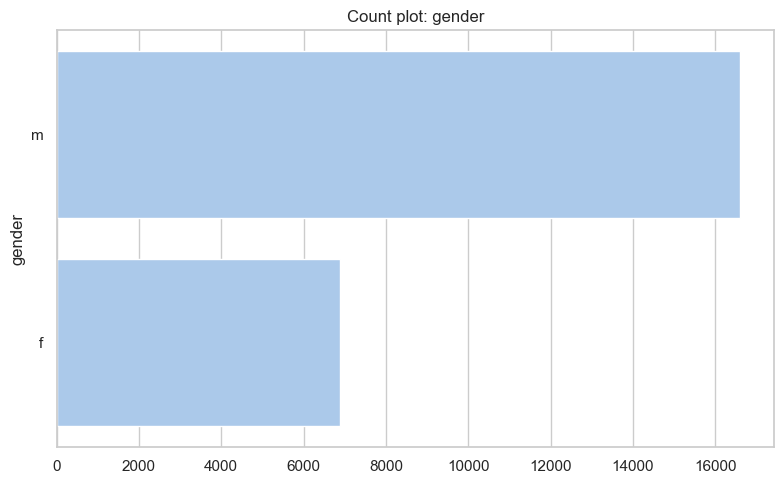

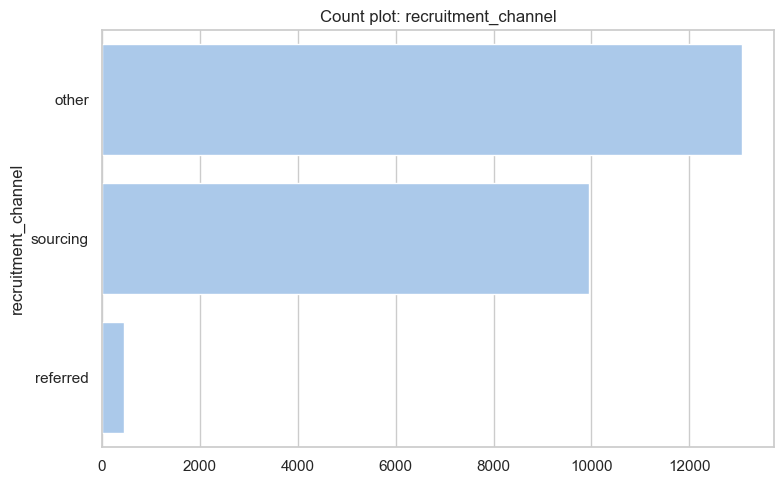

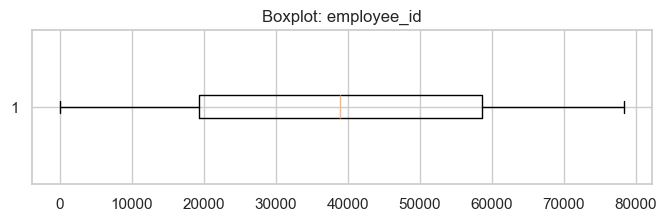

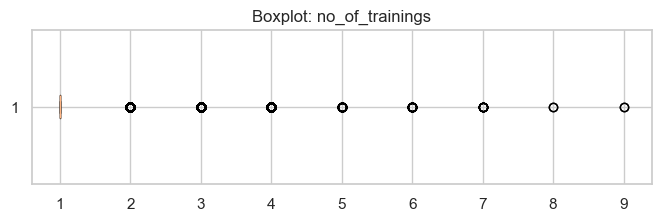

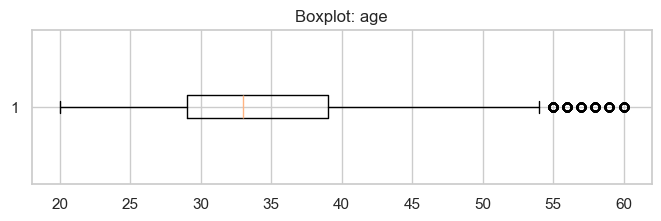

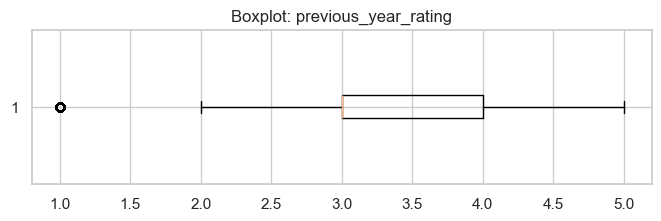

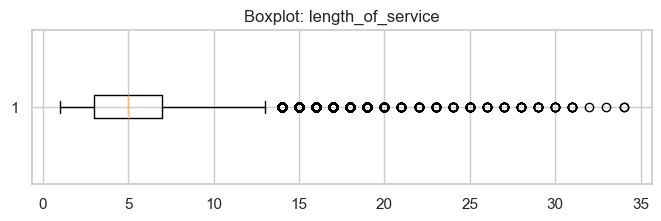

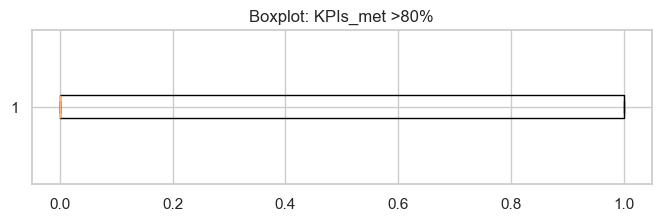

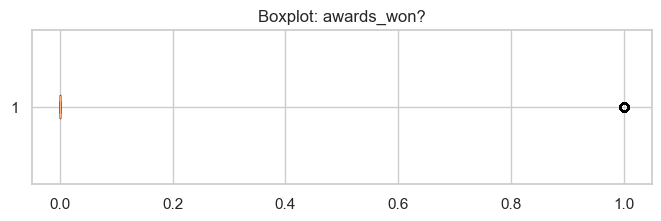

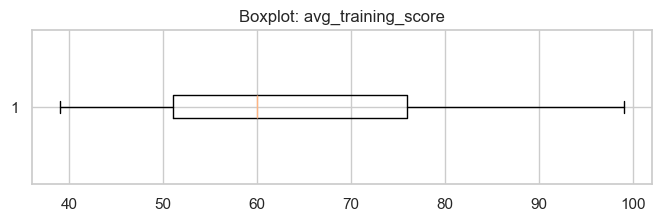

In [8]:

# EDA plots (saved to PLOTS_DIR). Safe filenames used.
cat_cols = df_clean.select_dtypes(include=['object','category','bool']).columns.tolist()
num_cols = df_clean.select_dtypes(include=['number']).columns.tolist()

# Categorical count plots
for col in cat_cols:
    try:
        vc = df_clean[col].value_counts().iloc[:50]
        plt.figure(figsize=(8,5))
        sns.barplot(x=vc.values, y=vc.index)
        plt.title(f'Count plot: {col}')
        plt.tight_layout()
        safe = sanitize_filename(col)
        plt.show()

    except Exception as e:
        print('Could not plot', col, e)

# Numeric histograms + boxplots
for col in num_cols:
    try:
        plt.figure(figsize=(8,4))
        sns.histplot(df_clean[col].dropna(), bins=30, kde=True)
        plt.title(f'Distribution: {col}')
        safe = sanitize_filename(col)
        plt.savefig(PLOTS_DIR / f'hist_{safe}.png', dpi=150, bbox_inches='tight')
        plt.close()
        plt.figure(figsize=(8,2))
        plt.boxplot(df_clean[col].dropna(), vert=False)
        plt.title(f'Boxplot: {col}')
        plt.show()
    
    except Exception as e:
        print('Could not plot numeric', col, e)




In [9]:

# Prepare features and target (auto-detect target)
def detect_target_column(df):
    candidates = ['target','Target','label','Label','y','Y','outcome']
    for c in candidates:
        if c in df.columns:
            return c
    return df.columns[-1]

def prepare_features(df, target_col=None):
    if target_col is None:
        target_col = detect_target_column(df)
    X = df.drop(columns=[target_col]).copy()
    y = df[target_col].copy()
    # Encode y if not numeric
    if not pd.api.types.is_numeric_dtype(y):
        le = LabelEncoder()
        y = le.fit_transform(y.astype(str))
        print('Target encoded. Classes:', le.classes_)
    else:
        # convert floats that are integers to int
        if pd.api.types.is_float_dtype(y) and (np.allclose(y, y.astype(int))):
            y = y.astype(int)
    # Encode categorical features ordinally
    cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()
    num_cols = X.select_dtypes(include=['number']).columns.tolist()
    if cat_cols:
        enc = OrdinalEncoder(dtype=float, handle_unknown='use_encoded_value', unknown_value=-1)
        X[cat_cols] = enc.fit_transform(X[cat_cols].astype(str))
    return X, y, num_cols, cat_cols, target_col

X, y, numeric_cols, categorical_cols, target_col = prepare_features(df_clean)
print('Target column:', target_col)
print('Numeric cols:', numeric_cols)
print('Categorical (encoded) cols:', categorical_cols)


Target column: avg_training_score
Numeric cols: ['employee_id', 'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'KPIs_met >80%', 'awards_won?']
Categorical (encoded) cols: ['department', 'region', 'education', 'gender', 'recruitment_channel']


In [ ]:

# Apply scalers function
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler
def apply_scalers(X, numeric_cols):
    scalers = {
        'RobustScaler': RobustScaler(),
        'StandardScaler': StandardScaler(),
        'MinMaxScaler': MinMaxScaler(),
        'MaxAbsScaler': MaxAbsScaler()
    }
    scaled_versions = {}
    for name, scaler in scalers.items():
        Xs = X.copy()
        if len(numeric_cols)>0:
            Xs[numeric_cols] = scaler.fit_transform(Xs[numeric_cols])
        scaled_versions[name] = Xs
    return scaled_versions

scaled_versions = apply_scalers(X, numeric_cols)
print('Generated scaled datasets:', list(scaled_versions.keys()))


In [ ]:

# Model factory with fallbacks
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
def get_models(random_state=42):
    models = {}
    notes = {}
    try:
        import xgboost as xgb
        models['XGBoost'] = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=150, random_state=random_state, n_jobs=4)
        notes['XGBoost'] = 'xgboost'
    except Exception:
        models['XGBoost'] = GradientBoostingClassifier(n_estimators=150, random_state=random_state)
        notes['XGBoost'] = 'fallback: sklearn.GradientBoostingClassifier'
    try:
        from catboost import CatBoostClassifier
        models['CatBoost'] = CatBoostClassifier(verbose=0, iterations=150, random_state=random_state)
        notes['CatBoost'] = 'catboost'
    except Exception:
        models['CatBoost'] = HistGradientBoostingClassifier(max_iter=150, random_state=random_state)
        notes['CatBoost'] = 'fallback: sklearn.HistGradientBoostingClassifier'
    try:
        import lightgbm as lgb
        models['LightGBM'] = lgb.LGBMClassifier(n_estimators=150, random_state=random_state, n_jobs=4)
        notes['LightGBM'] = 'lightgbm'
    except Exception:
        models['LightGBM'] = GradientBoostingClassifier(n_estimators=150, random_state=random_state)
        notes['LightGBM'] = 'fallback: sklearn.GradientBoostingClassifier'
    return models, notes

models, notes = get_models()
print('Models:', list(models.keys()))
print('Notes:', notes)


In [ ]:

# Training loop across scalers and models
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
results = []

def safe_train_test_split(X, y, test_size=0.2):
    counts = Counter(y)
    if len(counts)>1 and min(counts.values())>=2:
        return train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    else:
        return train_test_split(X, y, test_size=test_size, random_state=42)

for scaler_name, X_scaled in scaled_versions.items():
    for model_name, model in models.items():
        print(f'Running: {model_name} with {scaler_name} ...')
        try:
            X_train, X_test, y_train, y_test = safe_train_test_split(X_scaled, y)
            start = time.time()
            model.fit(X_train, y_train)
            train_time = time.time() - start
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            cm = confusion_matrix(y_test, y_pred)
            # Save confusion matrix heatmap
            plt.figure(figsize=(5,4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'{model_name} + {scaler_name} (acc={acc:.4f})')
            cm_path = PLOTS_DIR / f'cm_{sanitize_filename(model_name)}_{sanitize_filename(scaler_name)}.png'
            plt.savefig(cm_path, dpi=150, bbox_inches='tight')
            plt.close()
            results.append({
                'model': model_name,
                'scaler': scaler_name,
                'accuracy': float(acc),
                'cm_path': str(cm_path),
                'train_time_sec': float(train_time)
            })
            print(f' -> acc={acc:.4f}, time={train_time:.2f}s')
        except Exception as e:
            print('Training/eval failed for', model_name, scaler_name, e)

# Save summary
summary_df = pd.DataFrame(results).sort_values('accuracy', ascending=False).reset_index(drop=True)
summary_csv = OUTPUT_DIR / 'scaler_model_comparison_summary.csv'
summary_df.to_csv(summary_csv, index=False)
print('\nSaved summary to', summary_csv)
display(summary_df.head(10))


## What you get

- EDA plots saved in `/mnt/data/report_output/plot`
- Confusion matrices saved there too
- Summary CSV: `/mnt/data/report_output/scaler_model_comparison_summary.csv`

Open this notebook in Jupyter and run all cells. If you want, I can also run the notebook here and attach the generated summary and images — tell me if you'd like me to execute it now.